# Visualizing Climbing Data from 8a.nu using SQL and Tableau



### Introduction
Climbing has transformed from a off-the-beaten-path lifestyle, to a competitive sport now being featured in the 2021 olympics. Unlike a lot of other popular sports such as basketball and football, little data-driven information is available about climbers.


### Data
Luckily, kaggle has a great dataset of users from the world's largest rock climbing logbook, 8a.nu. The dataset was collected on 9/13/2017 can be found on kaggle https://www.kaggle.com/dcohen21/8anu-climbing-logbook. The data is held in a sqlite database. 

### Analytics
In order to undestand what insights we can gain from this dataset, we first need to understand what information is in tables.









    

In [28]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

## Understanding the sql data schema

In [2]:
#Make a connection
con = sqlite3.connect('database.sqlite')

#Make a cursor instance
c = con.cursor()

How many tables are in the sql database and what are their names?

In [3]:
#Look at all of the tables within the sqlite databes
def table_names():
    query = """
    SELECT NAME 
    FROM SQLITE_MASTER 
    WHERE type= 'table';
    """
    c.execute(query)
    
    tables = []
    for row in c.fetchall():
        tables.append(row[0])
    
    return tables

In [4]:
all_tables = table_names()

for table in all_tables:
    print(table)

user
method
grade
ascent


### Tables

There are 4 tables in the dataset:
1. user
2. method
3. grade
4. ascent

Next we need to know about the contents of each table including:

1. What columns are in each table?
2. How many rows are in each table?
3. How do the tables relate?

In [5]:
def col_info():
    #Get table names
    tables = table_names()
    
    #Initialize dataframes for each table
    dfs = {}

    for table in tables:
        #d[table] = pd.DataFrame()
        
        query = f"""
        PRAGMA table_info({table})
        """
        c.execute(query)
        
        Column = []
        Type = []
        Not_Null = []
        Primary_Key = []
        
        for row in c:
            Column.append(row[1])
            Type.append(row[2])
            if row[3]:
                Not_Null.append("YES")
            else:
                Not_Null.append("NO")
            if row[5]:
                Primary_Key.append("YES")
            else:
                Primary_Key.append("")
            
        dfs[table] = pd.DataFrame({"Column" : Column,
                          "Type" : Type,
                          "Not_Null" : Not_Null,
                          "Primary_Key" : Primary_Key})
    return dfs 

In [6]:
column_info_dfs = col_info()

In [7]:
column_info_dfs["user"]

,Column,Type,Not_Null,Primary_Key
0,id,INTEGER,YES,YES
1,first_name,VARCHAR,NO,
2,last_name,VARCHAR,NO,
3,city,VARCHAR,NO,
4,country,VARCHAR,NO,
5,sex,INTEGER,NO,
6,height,INTEGER,NO,
7,weight,INTEGER,NO,
8,started,INTEGER,NO,
9,competitions,VARCHAR,NO,


In [8]:
column_info_dfs["method"]

,Column,Type,Not_Null,Primary_Key
0,id,INTEGER,YES,YES
1,score,INTEGER,NO,
2,shorthand,VARCHAR,NO,
3,name,VARCHAR,NO,


In [9]:
column_info_dfs["grade"]

,Column,Type,Not_Null,Primary_Key
0,id,INTEGER,YES,YES
1,score,INTEGER,NO,
2,fra_routes,VARCHAR,NO,
3,fra_routes_input,BOOLEAN,NO,
4,fra_routes_selector,BOOLEAN,NO,
5,fra_boulders,VARCHAR,NO,
6,fra_boulders_input,BOOLEAN,NO,
7,fra_boulders_selector,BOOLEAN,NO,
8,usa_routes,VARCHAR,NO,
9,usa_routes_input,BOOLEAN,NO,


In [10]:
column_info_dfs["ascent"]

,Column,Type,Not_Null,Primary_Key
0,id,INTEGER,YES,YES
1,user_id,INTEGER,NO,
2,grade_id,INTEGER,NO,
3,notes,VARCHAR,NO,
4,raw_notes,INTEGER,NO,
5,method_id,INTEGER,NO,
6,climb_type,INTEGER,NO,
7,total_score,INTEGER,NO,
8,date,INTEGER,NO,
9,year,INTEGER,NO,


## Tables Summary

There are 4 tables, all of which can be joined on the primary key "id".

Next we need to know the number of records in each table.

In [11]:
def countRows():
    #Get table names
    tables = table_names()
    
    for table in tables:
        query = f"""
        SELECT COUNT(id)
        FROM {table}
        """
        count = c.execute(query).fetchall()[0][0]
        print(f"{table} table:  {count} rows")
        

In [12]:
countRows()

user table:  62593 rows
method table:  5 rows
grade table:  83 rows
ascent table:  4111877 rows


### Database Structure Insights

We can see that the largest tables is the ascent table with more than 4 million rows. The user table is the second largest around 63,000 rows. In the user table, each record represents a unique user (as indicated in the table name). Records such as name support this notion. The ascent table represents every unique "send" (a completed climbing boulder/route) for all users. 

1. Popularity
    - Number of climbers over time.
        - Segment by female and male climbers

2. The average climber
    - Ratio of Male vs Female
    - Height
    - Weight
    - Occupation
    - Location
    - Average and Max grade
    

3. Grade progression over time 
    - To understand climbing grade metrics, we will need to join the user table to the ascent table. 


### User data questions:
1. How many male climbers?
2. How many female climbers?
3. What is the growth of cimbing?
    - Looking at when climbers started climbing as metric

In [14]:
# Get count of all users who started in a given year



In [15]:
start_year_count_all = queryToDataframe("""
SELECT COUNT(started) AS total, started AS year
FROM user
WHERE year BETWEEN 1920 AND 2017
GROUP BY(year)
ORDER BY year DESC
""")

In [16]:
start_year_count_all[start_year_count_all["year"] < 1950]

,total,year
62,2,1945
63,1,1943
64,1,1942
65,1,1938
66,1,1929
67,1,1928
68,1,1925
69,1,1922
70,1,1920


In [24]:
year_count_segmented = queryToDataframe("""
WITH t AS
    (
    SELECT COUNT(started) AS total, started AS year
    FROM user
    WHERE year BETWEEN 1960 AND 2017
    GROUP BY(year)
    ),
f AS
    (
    SELECT COUNT(started) AS female, started AS year
    FROM user
    WHERE year BETWEEN 1960 AND 2017
        AND sex = 1
    GROUP BY(year)
    ),
m AS
    (
    SELECT COUNT(started) AS male, started AS year
    FROM user
    WHERE year BETWEEN 1960 AND 2017
        AND sex = 0
    GROUP BY(year)
    )
SELECT t.year, t.total, m.male, IFNULL(f.female, 0) AS female
FROM t
LEFT JOIN f
    ON t.year = f.year
LEFT JOIN m
    ON t.year = m.year
""")

In [25]:
year_count_segmented

,year,total,male,female
0,1960,5,5,0
1,1962,2,2,0
2,1963,3,3,0
3,1964,3,3,0
4,1965,4,4,0
5,1966,4,3,1
6,1967,5,5,0
7,1968,11,10,1
8,1969,6,6,0
9,1970,19,19,0


In [29]:
def write_csv(df, path, filename):
    """
    Takes a dataframe, path, and filename.
    Returns a written csv.
    Checks if the csv is already written, and if the path is correct.
    """
    file = os.path.join(path, filename)

    if os.path.exists(path):
        if os.path.exists(file):
            print(f"The csv {filename} already exists.")
        else:
            pd.DataFrame.to_csv(df, file)
    else:
        print(f"The path {path} does not exist.")

In [30]:
write_csv(year_count_segmented, "clean_data", "popularity_growth.csv")

In [127]:
pd.to_datetime(year_count_segmented["year"], format = '%Y').dt.year

0     1966
1     1968
2     1974
3     1976
4     1977
5     1980
6     1981
7     1983
8     1984
9     1985
10    1986
11    1987
12    1988
13    1989
14    1990
15    1991
16    1992
17    1993
18    1994
19    1995
20    1996
21    1997
22    1998
23    1999
24    2000
25    2001
26    2002
27    2003
28    2004
29    2005
30    2006
31    2007
32    2008
33    2009
34    2010
35    2011
36    2012
37    2013
38    2014
39    2015
40    2016
41    2017
Name: year, dtype: int64

In [128]:
def multiLinePlot(df, x, time = False, title = "", ylab = "", xlab = ""):
    if time:
        xvar = pd.to_datetime(df[x], format = '%Y').dt.year
        xvar = df[x]
        
    yvars = df.drop(columns = x)
    ycols = yvars.columns.values
    
    for col in ycols:
        plt.plot(xvar, df[col], label = col)
    
    plt.legend()
    
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)

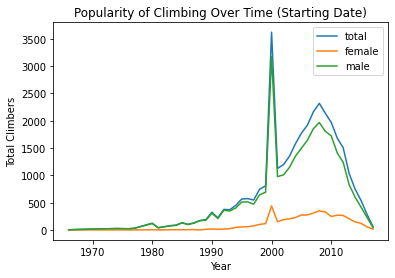

In [130]:
multiLinePlot(df = year_count_segmented, 
              x = "year", 
              time = True, 
              title = "Popularity of Climbing Over Time (Starting Date)",
              ylab = "Total Climbers",
              xlab = "Year")

How many climbers are male vs female?

In [96]:
sex_ratio = queryToDataframe("""
SELECT COUNT(*) AS count, 
    CASE WHEN sex = 0 THEN 'male'
         WHEN sex = 1 THEN 'female'
         ELSE 'NA'
    END AS sex
FROM user
GROUP BY sex
ORDER BY count DESC
""")

In [97]:
sex_ratio

,count,sex
0,53898,male
1,8691,female
2,4,NA


In [131]:
countryTop10 = queryToDataframe("""
SELECT COUNT(*) AS count, country
FROM user
GROUP BY country
ORDER BY count DESC
LIMIT 10
""")

In [132]:
countryTop10

,count,country
0,11861,USA
1,6905,ESP
2,3712,DEU
3,3629,SWE
4,3590,ITA
5,3326,FRA
6,3303,POL
7,2660,GBR
8,2062,BRA
9,1928,AUT


In [148]:
weight_average = queryToDataframe("""
SELECT AVG(weight) AS avg_weight, 
       AVG(height) AS avg_height,
       CASE WHEN sex = 0 THEN 'male'
            WHEN sex = 1 THEN 'female'
            ELSE 'NA'
    END AS sex
FROM user
GROUP BY sex
""")

In [149]:
weight_average

,avg_weight,avg_height,sex
0,34.961297,85.152065,male
1,21.729951,76.043263,female
2,0.000000,36.500000,NA


In [150]:
queryToDataframe("""
SELECT COUNT(*) AS count,
       AVG(weight) AS avg_weight, 
       AVG(height) AS avg_height,
       CASE WHEN sex = 0 THEN 'male'
            WHEN sex = 1 THEN 'female'
            ELSE 'NA'
    END AS sex
FROM user
GROUP BY sex
""")

,count,avg_weight,avg_height,sex
0,53898,34.961297,85.152065,male
1,8691,21.729951,76.043263,female
2,4,0.000000,36.500000,NA


In order to look at the routes people are climbing, we first need to segment the types of climbs people are doing including:

1. Bouldering
2. Routes

In [ ]:
queryToDataframe("""
SELECT 
    MAX(a.grade_id), a.climb_type AS bouldering, a.year, 
    g.fra_routes AS grade 
FROM ascent a, grade g
WHERE a.grade_id = g.id
GROUP BY user_id, bouldering, year
LIMIT 100
""")

In [158]:
column_info_dfs["grade"]["Column"]

0                        id
1                     score
2                fra_routes
3          fra_routes_input
4       fra_routes_selector
5              fra_boulders
6        fra_boulders_input
7     fra_boulders_selector
8                usa_routes
9          usa_routes_input
10      usa_routes_selector
11             usa_boulders
12       usa_boulders_input
13    usa_boulders_selector
Name: Column, dtype: object

In [43]:
queryToDataframe("""
SELECT first_name, sex
FROM user
ORDER BY RANDOM()
LIMIT 20
""")

,first_name,sex
0,Simeon,0
1,User,0
2,Ivan,0
3,Alfredo Polo,0
4,Mike,0
5,Protax,0
6,Leon,0
7,Natalia,1
8,Ronald,0
9,george,0


[('Leif',),
 ('Andreas',),
 ('Magnus',),
 ('Annika',),
 ('Joe',),
 ('Tim',),
 ('Jens',),
 ('Johan',),
 ('Bosse',),
 ('jens',)]

,id,score,shorthand,name
0,1,0,redpoint,Redpoint
1,2,53,flash,Flash
2,3,145,onsight,Onsight
3,4,-52,toprope,Toprope
4,5,95,onsight,Onsight


In [19]:
c.execute("""SELECT * FROM method LIMIT 5""").description[0][0]

'id'

In [22]:
queryToDataframe(c.execute("""SELECT * FROM method LIMIT 5"""))

['id', 'score', 'shorthand', 'name']

In [5]:
c.execute("""SELECT started FROM user LIMIT 5""").fetchall()

TypeError: 'tuple' object is not callable

In [5]:
#Read all data from the small method database
c.execute("""SELECT * FROM method""")
for row in c.fetchall():
    print(row)
    


(1, 0, 'redpoint', 'Redpoint')
(2, 53, 'flash', 'Flash')
(3, 145, 'onsight', 'Onsight')
(4, -52, 'toprope', 'Toprope')
(5, 95, 'onsight', 'Onsight')


In [6]:
Grade_raw_df = pd.read_sql_query("SELECT * FROM grade", con)
User_raw_df = pd.read_sql_query("SELECT * FROM user", con)
Method_raw_df = pd.read_sql_query("SELECT * FROM method", con)

In [3]:
#The ascent df crashes python
Ascent_raw_df = pd.read_sql_query("SELECT id, user_id, grade_id, method_id, climb_type, year FROM ascent", con)

In [4]:
Ascent_raw_df.head()

,grade_id,method_id,year
0,36,3,1999
1,36,3,1999
2,36,3,1999
3,36,3,1999
4,36,3,1999
